<a href="https://colab.research.google.com/github/srijeetadas/COVID_GAN/blob/main/COVID_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import sys, os, glob, time, imageio 
import numpy as np, pandas as pd  

import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image 

import torch 
import torchvision.utils as vutils 
import torchvision.transforms as transforms 

from keras import models, layers, optimizers 
from keras.models import Sequential 
from keras.preprocessing.image import array_to_img, img_to_array, load_img 
from keras.layers import Input, Dense, Conv2D, Add, Dot, Conv2DTranspose, Activation, Reshape, LeakyReLU, Flatten, BatchNormalization
import tensorflow as tf 

In [ ]:
path_root = '/content/drive/MyDrive/GAN_DATASET'
path_train= '/content/drive/MyDrive/GAN_DATASET/TRAIN/'
path_test = '/content/drive/MyDrive/GAN_DATASET/VAL/'

# Root paths for X-Ray images
XRay_normal     = glob.glob(path_root+'*/NORMAL/*.png', recursive=True)
XRay_covid = glob.glob(path_root+'*/COVID/*.png', recursive=True)

# Root paths for X-Ray training images
train_normal    = glob.glob(path_train+'NORMAL/*.png', recursive=True)
train_covid= glob.glob(path_train+'COVID/*.png', recursive=True)

# X-Ray testing images 
test_normal     = os.listdir(path_test+'NORMAL/')
test_covid = os.listdir(path_test+'COVID/')

print('The "Chest X-Ray Images" dataset contains {:04d} NORMAL and {:04d} COVID images ({:03d} in total)'\
      .format(len(XRay_normal), 
              len(XRay_covid),
              len(glob.glob(path_root+'*/*/*.png')),))
print('   - {:04d} NORMAL and {:04d} COVID ==> {:04d} images in the training sample'\
      .format(len(train_normal), 
              len(train_covid), 
              len(glob.glob(path_train+'*/*.png'))))
print('   - {:04d} NORMAL and {:04d} COVID ==> {:04d} images in the testing sample'\
      .format(len(test_normal), 
              len(test_covid), 
              len(glob.glob(path_test+'*/*.png'))))

The "Chest X-Ray Images" dataset contains 0000 NORMAL and 0000 COVID images (000 in total)
   - 1001 NORMAL and 1397 COVID ==> 2398 images in the training sample
   - 1999 NORMAL and 1505 COVID ==> 3504 images in the testing sample


In [ ]:
def _time(start, end): 
    # if in seconds 
    if (end-start)<60: 
        wall_time = f'{round((end-start),2)}sec'
    # if in minute(s)  
    elif (end-start)>=3600: 
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    # if in houre(s)  
    else: 
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time

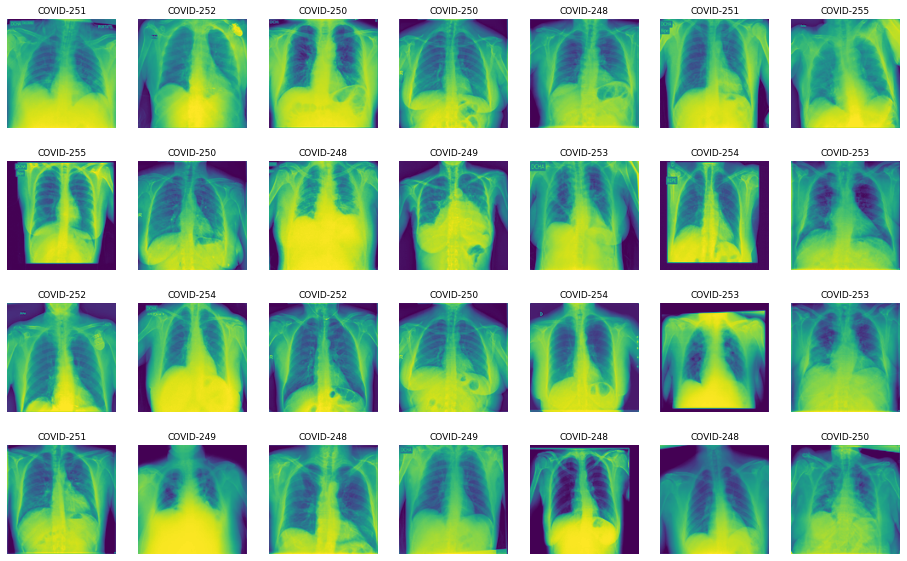

In [ ]:
nrows, ncols = 4, 7
plt.figure(figsize=(16,10))
for idx, name in enumerate(test_covid[:nrows*ncols]):
    plt.subplot(nrows, ncols, idx+1)
    img = Image.open(path_test+'COVID/'+name) # or use plt.imread(path_test+'NORMAL/'+name)
    img = img.resize(size=(128, 128), resample=Image.ANTIALIAS, box=None)
    plt.imshow(img)
    plt.title(name[:-5], fontsize=9)
    plt.axis('off')

In [ ]:
def get_data(data_path, dim=(128, 128), rand_shuffle=True): 
    start = time.time() 
    imgs_data = []         
    sample_size = len(data_path)
    for idx, im_path in enumerate(data_path): 
        if idx%(sample_size//10)==0:
            print('Processing index {:05d} of {:05d} ==> {:03d}%'\
                  .format(idx, sample_size, round(100*idx/sample_size))) 
        img = img_to_array(load_img(im_path, target_size = dim)) 
        imgs_data.append(img) 
        
    # to float 
    imgs_data = np.array(imgs_data).astype('float32') 
    # scale to [0,1] (note the . after 255 - float)
    imgs_data = imgs_data/255. #for formalizing to [-1,1] ==> (imgs_data - 127.5)/127.5 
    
    # shuffle the data 
    if rand_shuffle: 
        idx = np.arange(imgs_data.shape[0])
        np.random.shuffle(idx) 
        imgs_data = imgs_data[idx,:,:,:] 
    
    print(f"Hey! the calculations are done in {_time(start, time.time())}")
    return imgs_data

In [ ]:
print('Starting for NORMAL X-Ray images ...')
X_normal = get_data(train_normal)
print()
print('Starting for COVID X-Ray images ...')
X_covid = get_data(train_covid)

Starting for NORMAL X-Ray images ...
Processing index 00000 of 01001 ==> 000%
Processing index 00100 of 01001 ==> 010%
Processing index 00200 of 01001 ==> 020%
Processing index 00300 of 01001 ==> 030%
Processing index 00400 of 01001 ==> 040%
Processing index 00500 of 01001 ==> 050%
Processing index 00600 of 01001 ==> 060%
Processing index 00700 of 01001 ==> 070%
Processing index 00800 of 01001 ==> 080%
Processing index 00900 of 01001 ==> 090%
Processing index 01000 of 01001 ==> 100%
Hey! the calculations are done in 3min 1.48sec

Starting for COVID X-Ray images ...
Processing index 00000 of 01397 ==> 000%
Processing index 00139 of 01397 ==> 010%
Processing index 00278 of 01397 ==> 020%
Processing index 00417 of 01397 ==> 030%
Processing index 00556 of 01397 ==> 040%
Processing index 00695 of 01397 ==> 050%
Processing index 00834 of 01397 ==> 060%
Processing index 00973 of 01397 ==> 070%
Processing index 01112 of 01397 ==> 080%
Processing index 01251 of 01397 ==> 090%
Processing index 0

In [ ]:
def define_grid(data_images, nrows=4, ncols=5, plot_grid=True):
    # save the started time 
    start = time.time() 
    # Number of GPUs available. Use 0 for CPU mode. 
    ngpu = 1 
    # Decide which device we want to run on 
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    # Rearange the shaphe of the data 
    data_transp = [np.transpose(data_images[i,:,:]) for i in range(data_images[:nrows*ncols].shape[0])]
    # From to torch type for the grid 
    data_transp = torch.Tensor(data_transp)
    print(f'The shape is reordered from {data_images.shape[1:]} to {data_transp.shape[1:]} in {_time(start, time.time())}')
    
    # Make the grid 
    grid_images = np.transpose(
        vutils.make_grid(
            data_transp.to(device)[:nrows*ncols], 
            nrow=nrows,
            padding=2,
            normalize=True,
            scale_each=True,
            pad_value=1,
        ).cpu(), axes=(2,1,0))
        
    # Show the output grid 
    if plot_grid:
        plt.figure(figsize=(12,12)) 
        plt.axis("off") 
        plt.title(f'Grid of {nrows*ncols} real images', fontsize=27)
        plt.imshow(grid_images)
        
    return grid_images

grid_X_normal = define_grid(X_normal, plot_grid=False)
grid_X_covid = define_grid(X_covid, plot_grid=False)

The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.17sec
The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128]) in 0.09sec


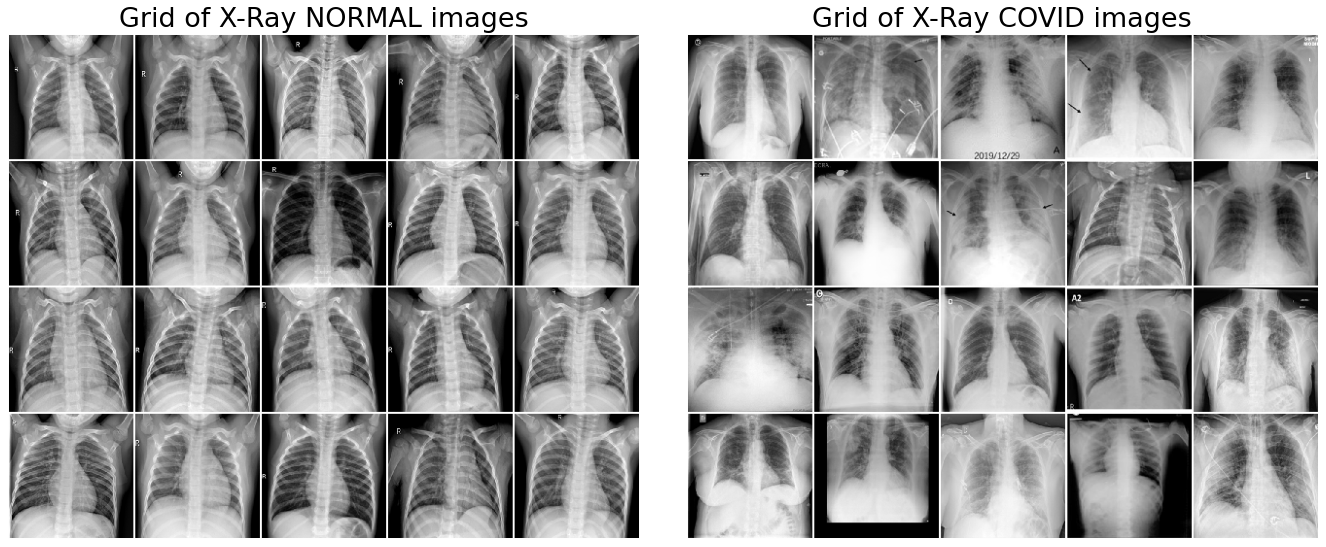

In [ ]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(19, 8))

ax1.imshow(grid_X_normal); ax1.axis('off')
ax1.set_title(label = 'Grid of X-Ray NORMAL images', fontsize = 27)

ax2.imshow(grid_X_covid); ax2.axis('off')
ax2.set_title(label = 'Grid of X-Ray COVID images', fontsize = 27)

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=[0, 0.03, 1, 0.95])

In [ ]:
# Number of images to use
#n_images = 12_000 

# Number of training epochs
n_epoch = 400

# Batch size during training 
batch_size = 32 #128 

# Size of z latent vector (i.e. size of generator input) 
latent_dim = 128 #100 

# Spatial size of training images. All images will be resized to this size 
cols, rows = 128, 128 

# Number of channels in the training images. For RGB color images this is 3
channels = 3 
dim = cols, rows # height, width 
in_shape = (cols, rows, channels) # height, width, color 

# Learning rate for optimizers
lr = 0.0002 #0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 

# plot ncols images in row and nrows images in colomn
nrows, ncols = 3, 4

In [ ]:
def define_discriminator(in_shape=(128,128,3)): 
    model = models.Sequential() 
    # normal 
    model.add(layers.Conv2D(128, (5,5), padding='same', input_shape=in_shape)) 
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 64x64 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 32x32 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 16x16 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 8x8 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # classifier 
    model.add(layers.Flatten()) 
    model.add(layers.Dropout(0.4)) 
    model.add(layers.Dense(1, activation='sigmoid')) 
    # compile model 
    opt = optimizers.Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
    return model

In [ ]:
def define_generator(latent_dim):
    model = models.Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128*8*8
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model 

#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input 

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [ ]:
def define_gan(g_model, d_model): 
    # make weights in the discriminator not trainable
    d_model.trainable = False 
    # connect them
    model = models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# create and save a plot of generated images 
def show_generated(generated, epoch, nrows=4, ncols=5):
    #[-1,1] -> [0,1] 
    #generated = (generated+1)/2 
    #generated = (generated[:ncols*nrows]*127.5)+127.5 
    #generated = generated*255 
    plt.figure(figsize=(10,10)) 
    for idx in range(nrows*ncols): 
        plt.subplot(nrows, ncols, idx+1) 
        plt.imshow(generated[idx]) 
        plt.axis('off') 
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1)) 
    plt.show() 

# evaluate the discriminator and plot generated images 
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples 
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance 
    print('> Accuracy at epoch %d [real: %.0f%%, fake: %.0f%%]'%(epoch+1, acc_real*100, acc_fake*100))
    # show plot 
    show_generated(x_fake, epoch)  
    
def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20) 
    plt.plot(loss[0], label="D_real") 
    plt.plot(loss[1], label="D_fake") 
    plt.plot(loss[2], label="G") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim=128, n_epochs=300, n_batch=32):
    
    start = time.time() 
    bat_per_epo = int(dataset.shape[0]/n_batch) 
    half_batch = int(n_batch/2) 
    loss1, loss2, loss3, acc1, acc2 = [], [], [], [], []
    fake_liste = [] 
    
    # manually enumerate epochs
    print('Training Start...')
    for i in range(n_epochs):
        start1 = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            loss1.append(d_loss1); loss2.append(d_loss2); loss3.append(g_loss); acc1.append(d_acc1); acc2.append(d_acc2)
        
        print('Epoch: {:03d}/{:03d}, Loss: [D_real = {:2.3f}, D_fake = {:2.3f}, G = {:2.3f}], time: {:s}'\
              .format(i+1,n_epochs,d_loss1,d_loss2,g_loss, _time(start1,time.time())))
        # evaluate the model performance 
        if (i+1)%(n_epochs//10) == 0: 
            # Save and show generated images 
            summarize_performance(i, g_model, d_model, dataset, latent_dim) 
        
    print('Total time for training {} epochs is {} sec'.format(n_epochs, _time(start, time.time())))
    
    # Show loss curves 
    loss = (loss1, loss2, loss3) 
    plot_loss(loss)

In [ ]:
discriminator = define_discriminator() 
generator = define_generator(latent_dim) 
generator.summary()
discriminator.summary()
# create the gan 
gan = define_gan(generator, discriminator)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training Start...
Epoch: 001/400, Loss: [D_real = 0.024, D_fake = 0.922, G = 0.607], time: 1min 10.46sec
Epoch: 002/400, Loss: [D_real = 0.064, D_fake = 0.541, G = 0.929], time: 19.2sec
Epoch: 003/400, Loss: [D_real = 0.378, D_fake = 0.551, G = 1.729], time: 19.38sec
Epoch: 004/400, Loss: [D_real = 0.669, D_fake = 0.643, G = 0.920], time: 19.54sec
Epoch: 005/400, Loss: [D_real = 0.690, D_fake = 0.887, G = 0.847], time: 19.7sec
Epoch: 006/400, Loss: [D_real = 0.570, D_fake = 0.556, G = 0.961], time: 19.8sec
Epoch: 007/400, Loss: [D_real = 0.662, D_fake = 0.598, G = 0.914], time: 19.83sec
Epoch: 008/400, Loss: [D_real = 0.622, D_fake = 0.674, G = 0.828], time: 19.97sec
Epoch: 009/400, Loss: [D_real = 0.643, D_fake = 0.566, G = 0.982], time: 20.14sec
Epoch: 010/400, Loss: [D_real = 0.488, D_fake = 0.624, G = 0.915], time: 20.24sec
Epoch: 011/400, Loss: [D_real = 0.666, D_fake = 0.579, G = 1.018], time: 20.34sec
Epoch: 012/400, Loss: [D_real = 0.615, D_fake = 0.642, G = 0.929], time: 20.31

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 40 [real: 77%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


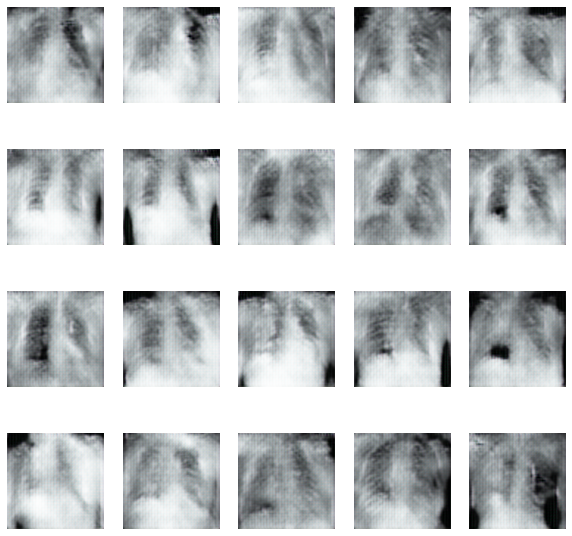

Epoch: 041/400, Loss: [D_real = 0.681, D_fake = 1.092, G = 1.936], time: 20.51sec
Epoch: 042/400, Loss: [D_real = 0.370, D_fake = 0.399, G = 2.104], time: 20.51sec
Epoch: 043/400, Loss: [D_real = 0.486, D_fake = 0.479, G = 1.796], time: 20.47sec
Epoch: 044/400, Loss: [D_real = 0.419, D_fake = 0.039, G = 7.516], time: 20.29sec
Epoch: 045/400, Loss: [D_real = 0.011, D_fake = 0.031, G = 4.773], time: 20.48sec
Epoch: 046/400, Loss: [D_real = 0.124, D_fake = 0.102, G = 2.926], time: 20.37sec
Epoch: 047/400, Loss: [D_real = 0.492, D_fake = 0.376, G = 2.475], time: 20.63sec
Epoch: 048/400, Loss: [D_real = 0.514, D_fake = 0.547, G = 3.037], time: 20.37sec
Epoch: 049/400, Loss: [D_real = 0.316, D_fake = 0.612, G = 2.726], time: 20.47sec
Epoch: 050/400, Loss: [D_real = 0.232, D_fake = 0.570, G = 1.690], time: 20.57sec
Epoch: 051/400, Loss: [D_real = 0.406, D_fake = 0.703, G = 1.755], time: 20.4sec
Epoch: 052/400, Loss: [D_real = 0.726, D_fake = 0.559, G = 1.397], time: 20.52sec
Epoch: 053/400, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 80 [real: 62%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


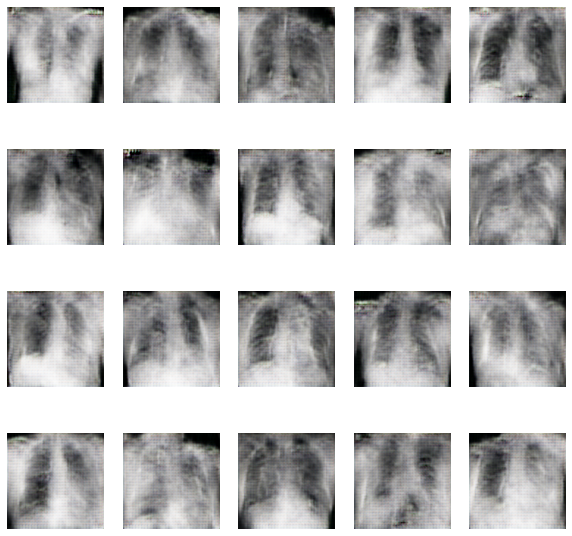

Epoch: 081/400, Loss: [D_real = 0.575, D_fake = 0.359, G = 1.662], time: 20.57sec
Epoch: 082/400, Loss: [D_real = 0.434, D_fake = 0.409, G = 1.863], time: 20.58sec
Epoch: 083/400, Loss: [D_real = 0.670, D_fake = 0.320, G = 1.486], time: 20.62sec
Epoch: 084/400, Loss: [D_real = 0.684, D_fake = 0.523, G = 1.474], time: 20.48sec
Epoch: 085/400, Loss: [D_real = 0.397, D_fake = 0.516, G = 1.953], time: 20.52sec
Epoch: 086/400, Loss: [D_real = 0.579, D_fake = 0.421, G = 1.694], time: 20.51sec
Epoch: 087/400, Loss: [D_real = 0.317, D_fake = 0.377, G = 1.938], time: 20.35sec
Epoch: 088/400, Loss: [D_real = 0.545, D_fake = 0.302, G = 1.618], time: 20.48sec
Epoch: 089/400, Loss: [D_real = 0.323, D_fake = 0.438, G = 1.542], time: 20.63sec
Epoch: 090/400, Loss: [D_real = 0.355, D_fake = 0.424, G = 2.092], time: 20.62sec
Epoch: 091/400, Loss: [D_real = 0.861, D_fake = 0.463, G = 1.461], time: 20.41sec
Epoch: 092/400, Loss: [D_real = 0.291, D_fake = 0.507, G = 2.089], time: 20.49sec
Epoch: 093/400, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 120 [real: 68%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


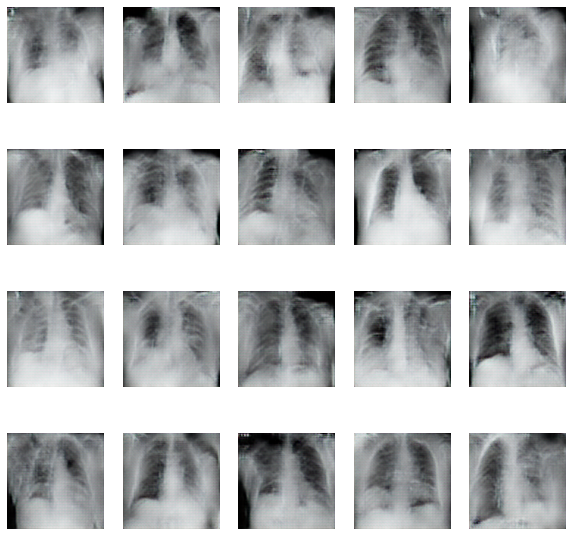

Epoch: 121/400, Loss: [D_real = 0.464, D_fake = 0.608, G = 2.350], time: 20.61sec
Epoch: 122/400, Loss: [D_real = 0.257, D_fake = 0.334, G = 2.995], time: 20.55sec
Epoch: 123/400, Loss: [D_real = 0.559, D_fake = 0.249, G = 1.805], time: 20.62sec
Epoch: 124/400, Loss: [D_real = 0.653, D_fake = 0.566, G = 2.010], time: 20.45sec
Epoch: 125/400, Loss: [D_real = 0.401, D_fake = 0.169, G = 2.258], time: 20.46sec
Epoch: 126/400, Loss: [D_real = 0.342, D_fake = 0.176, G = 2.469], time: 20.62sec
Epoch: 127/400, Loss: [D_real = 0.263, D_fake = 0.325, G = 2.558], time: 20.43sec
Epoch: 128/400, Loss: [D_real = 0.096, D_fake = 0.149, G = 2.987], time: 20.62sec
Epoch: 129/400, Loss: [D_real = 0.616, D_fake = 0.606, G = 2.724], time: 20.43sec
Epoch: 130/400, Loss: [D_real = 0.496, D_fake = 0.767, G = 2.318], time: 20.41sec
Epoch: 131/400, Loss: [D_real = 0.155, D_fake = 0.303, G = 2.719], time: 20.59sec
Epoch: 132/400, Loss: [D_real = 0.089, D_fake = 0.562, G = 3.086], time: 20.55sec
Epoch: 133/400, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 160 [real: 79%, fake: 97%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


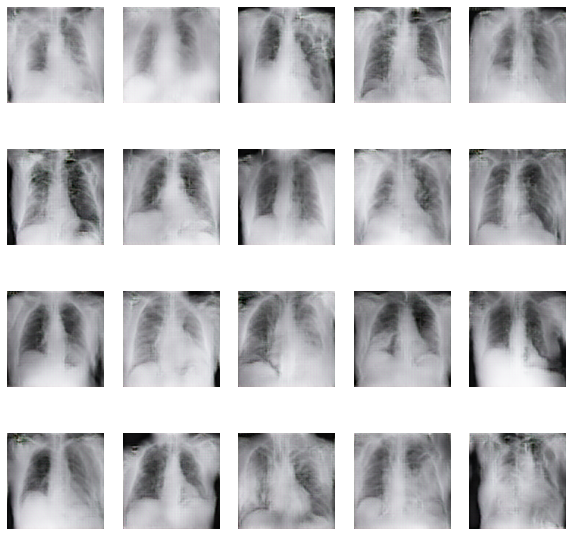

Epoch: 161/400, Loss: [D_real = 0.195, D_fake = 0.296, G = 2.735], time: 20.54sec
Epoch: 162/400, Loss: [D_real = 0.399, D_fake = 0.742, G = 2.316], time: 20.46sec
Epoch: 163/400, Loss: [D_real = 0.158, D_fake = 0.276, G = 2.753], time: 20.45sec
Epoch: 164/400, Loss: [D_real = 0.231, D_fake = 0.445, G = 2.925], time: 20.67sec
Epoch: 165/400, Loss: [D_real = 0.412, D_fake = 0.237, G = 2.943], time: 20.4sec
Epoch: 166/400, Loss: [D_real = 0.194, D_fake = 0.236, G = 2.637], time: 20.42sec
Epoch: 167/400, Loss: [D_real = 0.304, D_fake = 0.155, G = 3.347], time: 20.68sec
Epoch: 168/400, Loss: [D_real = 0.224, D_fake = 0.401, G = 2.147], time: 20.51sec
Epoch: 169/400, Loss: [D_real = 0.317, D_fake = 0.447, G = 2.894], time: 20.52sec
Epoch: 170/400, Loss: [D_real = 0.315, D_fake = 0.353, G = 2.110], time: 20.58sec
Epoch: 171/400, Loss: [D_real = 0.214, D_fake = 0.246, G = 1.811], time: 20.51sec
Epoch: 172/400, Loss: [D_real = 0.373, D_fake = 0.158, G = 2.476], time: 20.48sec
Epoch: 173/400, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 200 [real: 88%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


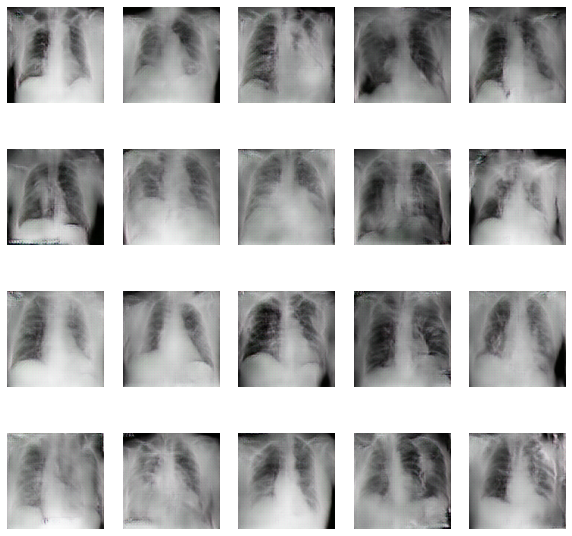

Epoch: 201/400, Loss: [D_real = 0.239, D_fake = 0.246, G = 2.703], time: 20.46sec
Epoch: 202/400, Loss: [D_real = 0.217, D_fake = 0.581, G = 3.440], time: 20.57sec
Epoch: 203/400, Loss: [D_real = 0.434, D_fake = 0.116, G = 2.714], time: 20.44sec
Epoch: 204/400, Loss: [D_real = 0.220, D_fake = 0.188, G = 3.077], time: 20.53sec
Epoch: 205/400, Loss: [D_real = 0.093, D_fake = 0.414, G = 5.240], time: 20.42sec
Epoch: 206/400, Loss: [D_real = 0.244, D_fake = 0.399, G = 3.609], time: 20.6sec
Epoch: 207/400, Loss: [D_real = 0.217, D_fake = 0.515, G = 3.258], time: 20.5sec
Epoch: 208/400, Loss: [D_real = 0.281, D_fake = 0.121, G = 3.124], time: 20.43sec
Epoch: 209/400, Loss: [D_real = 0.402, D_fake = 0.162, G = 2.243], time: 20.48sec
Epoch: 210/400, Loss: [D_real = 0.166, D_fake = 0.194, G = 3.371], time: 20.53sec
Epoch: 211/400, Loss: [D_real = 1.045, D_fake = 75.012, G = 1.094], time: 20.44sec
Epoch: 212/400, Loss: [D_real = 0.651, D_fake = 0.231, G = 7.517], time: 20.31sec
Epoch: 213/400, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 240 [real: 91%, fake: 97%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


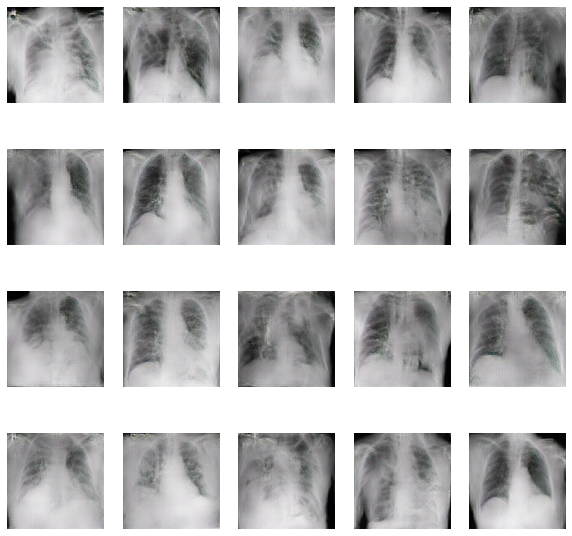

Epoch: 241/400, Loss: [D_real = 0.224, D_fake = 0.193, G = 2.321], time: 20.54sec
Epoch: 242/400, Loss: [D_real = 0.065, D_fake = 0.264, G = 2.932], time: 20.61sec
Epoch: 243/400, Loss: [D_real = 0.750, D_fake = 0.177, G = 2.766], time: 20.41sec
Epoch: 244/400, Loss: [D_real = 0.427, D_fake = 0.310, G = 2.829], time: 20.44sec
Epoch: 245/400, Loss: [D_real = 0.166, D_fake = 0.071, G = 2.343], time: 20.45sec
Epoch: 246/400, Loss: [D_real = 0.189, D_fake = 0.407, G = 3.098], time: 20.42sec
Epoch: 247/400, Loss: [D_real = 0.140, D_fake = 0.216, G = 3.134], time: 20.34sec
Epoch: 248/400, Loss: [D_real = 0.223, D_fake = 0.219, G = 3.505], time: 20.77sec
Epoch: 249/400, Loss: [D_real = 0.371, D_fake = 0.166, G = 2.949], time: 20.51sec
Epoch: 250/400, Loss: [D_real = 0.113, D_fake = 0.196, G = 3.513], time: 20.52sec
Epoch: 251/400, Loss: [D_real = 0.244, D_fake = 0.198, G = 3.012], time: 20.47sec
Epoch: 252/400, Loss: [D_real = 0.391, D_fake = 0.234, G = 2.629], time: 20.57sec
Epoch: 253/400, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 280 [real: 38%, fake: 90%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

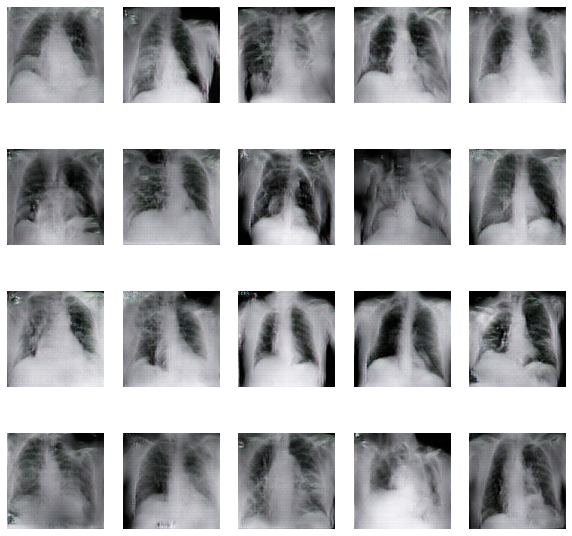

Epoch: 281/400, Loss: [D_real = 0.703, D_fake = 0.698, G = 1.610], time: 20.45sec
Epoch: 282/400, Loss: [D_real = 0.652, D_fake = 0.674, G = 2.274], time: 20.62sec
Epoch: 283/400, Loss: [D_real = 0.359, D_fake = 0.218, G = 2.652], time: 20.55sec
Epoch: 284/400, Loss: [D_real = 0.222, D_fake = 0.239, G = 2.382], time: 20.59sec
Epoch: 285/400, Loss: [D_real = 0.294, D_fake = 0.602, G = 3.162], time: 20.4sec
Epoch: 286/400, Loss: [D_real = 0.256, D_fake = 0.130, G = 2.667], time: 20.6sec
Epoch: 287/400, Loss: [D_real = 0.462, D_fake = 0.301, G = 2.441], time: 20.48sec
Epoch: 288/400, Loss: [D_real = 0.334, D_fake = 0.316, G = 2.441], time: 20.42sec
Epoch: 289/400, Loss: [D_real = 0.145, D_fake = 0.348, G = 3.487], time: 20.65sec
Epoch: 290/400, Loss: [D_real = 0.327, D_fake = 0.129, G = 3.067], time: 20.45sec
Epoch: 291/400, Loss: [D_real = 0.555, D_fake = 0.687, G = 2.775], time: 20.68sec
Epoch: 292/400, Loss: [D_real = 0.189, D_fake = 0.609, G = 3.131], time: 20.47sec
Epoch: 293/400, Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 320 [real: 93%, fake: 97%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


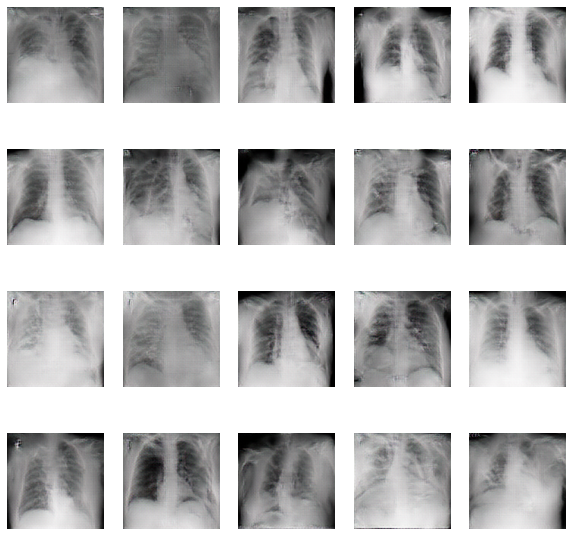

Epoch: 321/400, Loss: [D_real = 0.234, D_fake = 0.316, G = 2.915], time: 20.54sec
Epoch: 322/400, Loss: [D_real = 0.770, D_fake = 0.189, G = 3.024], time: 20.52sec
Epoch: 323/400, Loss: [D_real = 0.099, D_fake = 0.134, G = 3.011], time: 20.52sec
Epoch: 324/400, Loss: [D_real = 0.404, D_fake = 0.297, G = 4.377], time: 20.41sec
Epoch: 325/400, Loss: [D_real = 0.063, D_fake = 0.122, G = 4.037], time: 20.39sec
Epoch: 326/400, Loss: [D_real = 0.021, D_fake = 0.132, G = 3.196], time: 20.64sec
Epoch: 327/400, Loss: [D_real = 0.131, D_fake = 0.109, G = 3.881], time: 20.5sec
Epoch: 328/400, Loss: [D_real = 0.382, D_fake = 0.270, G = 3.100], time: 20.58sec
Epoch: 329/400, Loss: [D_real = 0.168, D_fake = 0.445, G = 4.533], time: 20.48sec
Epoch: 330/400, Loss: [D_real = 0.075, D_fake = 0.099, G = 4.044], time: 20.5sec
Epoch: 331/400, Loss: [D_real = 0.036, D_fake = 0.129, G = 4.014], time: 20.54sec
Epoch: 332/400, Loss: [D_real = 0.700, D_fake = 0.352, G = 3.372], time: 20.49sec
Epoch: 333/400, Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 360 [real: 92%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


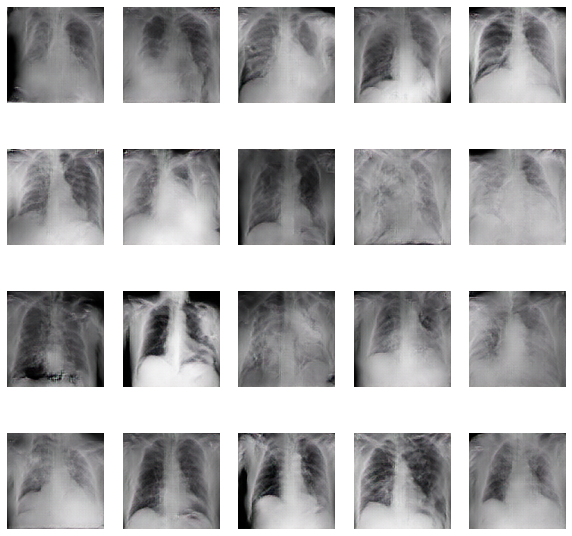

Epoch: 361/400, Loss: [D_real = 0.230, D_fake = 0.134, G = 4.179], time: 20.45sec
Epoch: 362/400, Loss: [D_real = 0.065, D_fake = 0.517, G = 4.644], time: 20.55sec
Epoch: 363/400, Loss: [D_real = 0.174, D_fake = 0.360, G = 4.701], time: 20.63sec
Epoch: 364/400, Loss: [D_real = 0.063, D_fake = 0.023, G = 6.122], time: 20.69sec
Epoch: 365/400, Loss: [D_real = 0.072, D_fake = 0.104, G = 5.268], time: 20.57sec
Epoch: 366/400, Loss: [D_real = 0.125, D_fake = 0.044, G = 5.208], time: 20.48sec
Epoch: 367/400, Loss: [D_real = 0.271, D_fake = 0.008, G = 4.791], time: 20.46sec
Epoch: 368/400, Loss: [D_real = 0.039, D_fake = 0.309, G = 4.499], time: 20.55sec
Epoch: 369/400, Loss: [D_real = 0.269, D_fake = 0.044, G = 5.695], time: 20.5sec
Epoch: 370/400, Loss: [D_real = 0.014, D_fake = 0.283, G = 4.334], time: 20.83sec
Epoch: 371/400, Loss: [D_real = 0.110, D_fake = 0.378, G = 4.358], time: 20.43sec
Epoch: 372/400, Loss: [D_real = 0.179, D_fake = 0.077, G = 3.335], time: 20.64sec
Epoch: 373/400, L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 400 [real: 69%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

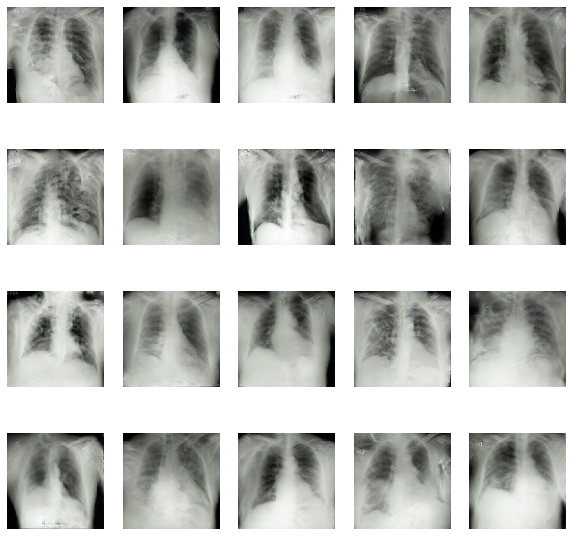

Total time for training 400 epochs is 2h 17min 45.15sec sec


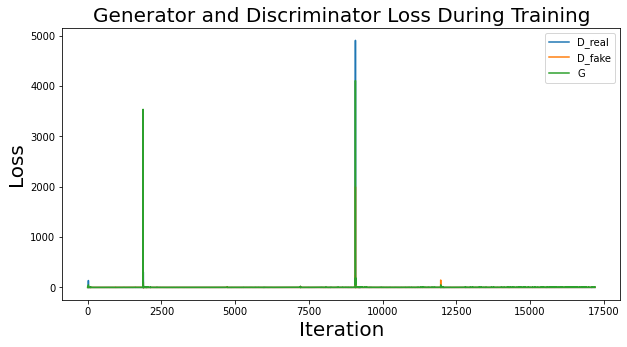

In [ ]:
train(generator, discriminator, gan, X_covid, latent_dim, n_epochs=n_epoch, n_batch=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

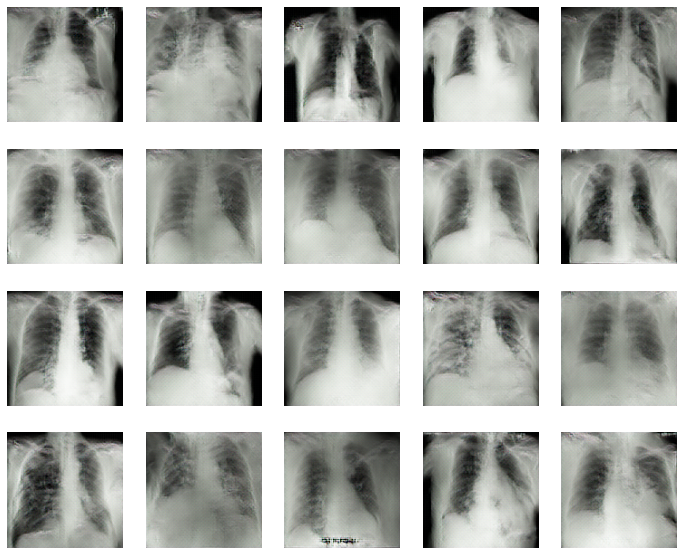

In [ ]:
def XRayFakeGenerator(g_model=generator, latent_dim = 128, n_samples=100, show_gen=True):
    # generate points in latent space 
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs 
    X = g_model.predict(x_input)  
    
    # Show the generated images
    if show_gen and n_samples<=30: 
        ncols = 5
        nrows = int(n_samples/ncols)
        plt.figure(figsize=(12,10)) 
        for idx in range(nrows*ncols): 
            plt.subplot(nrows, ncols, idx+1)
            plt.imshow(X[idx,:,:]); plt.axis('off')
        plt.show();
    return X 

XRay_fake = XRayFakeGenerator(generator, n_samples=20)

In [ ]:
import zipfile
output_path = zipfile.PyZipFile('/content/drive/MyDrive/GAN_DATASET/x_covid.zip', mode='w')

XRay_generated = XRayFakeGenerator(n_samples=1000)
for idx in range(XRay_generated.shape[0]):
    img_XRayFake  = XRay_generated[idx,:,:]
    name_XRayFake = 'XRay_generated {:04d}.png'.format(idx)
    imageio.imwrite(name_XRayFake, img_XRayFake)
    
    output_path.write(name_XRayFake)
    os.remove(name_XRayFake) 
output_path.close()